In [270]:
from CHECLabPy.core.io import HDF5Reader
from CHECLabPy.spectrum_fitters import SiPMGentileFitter, SpectrumParameter
import numpy as np
from numpy.polynomial.polynomial import polyfit, polyval
import pandas as pd
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

In [325]:
with HDF5Reader("charge_lab.h5") as reader:
    spe_df_lab = reader.read('spe')

Opening HDF5 file: charge_lab.h5
Reading entire DataFrame (spe) from HDF5 file into memory
[0.62025 0.84839 1.09235]


In [326]:
def fit_spe(df):
    illuminations = []
    charges = []
    for illumination, group in df.groupby("estimated_illumination_pe"):
        charge = group['charge'].values
        illuminations.append(illumination)
        charges.append(charge)

    fitter = SiPMGentileFitter(n_illuminations=len(charges))
    fitter.range = [-1.5, 5]
    fitter.n_bins = 60
    fitter.parameters.update([
        SpectrumParameter("spe", 0.2, (0, 5.0)),
        SpectrumParameter("spe_sigma", 0.1, (0.001, 1)),
        SpectrumParameter("eped", 0, (-2, 2)),
        SpectrumParameter("eped_sigma", 0.1, (0.0001, 1)),
        SpectrumParameter("opct", 0.4, (0.1, 0.6)),
        #SpectrumParameter("lambda_", 0.1, (0.01, 0.2), multi=True),
    ])
    fitter.apply(*charges)
    
    results = dict()
    results['n_illuminations'] = fitter.n_illuminations
    for coeff, value in fitter.fit_result_values.items():
        results[coeff] = value
    for coeff, value in fitter.fit_result_errors.items():
        results[f"{coeff}_err"] = value
        
    hist_x, hist_y, hist_edges = fitter.charge_histogram
    fit_x, fit_y = fitter.fit_result_curve
    
    results['hist_x'] = hist_x
    results['hist_edges'] = hist_edges
    results['fit_x'] = fit_x
    for i in range(fitter.n_illuminations):
        results[f'estimated_illumination_pe{i}'] = illuminations[i]
        results[f'hist_y{i}'] = hist_y[i]
        results[f'fit_y{i}'] = fit_y[i]
        results[f'average{i}'] = charges[i].mean()
    
    return results

In [327]:
fit_lab = fit_spe(spe_df_lab)
print(fit_lab['eped'])
for i in range(fit_lab['n_illuminations']):
    print((fit_lab[f'average{i}'] - fit_lab['eped']) / fit_lab[f'lambda_{i}'])

-5.910171608669579e-05
1.0046814727731213
1.0220032136564208
1.0236985835705077


In [340]:
def plot_fit(fit):
    for i in range(fit['n_illuminations']):
        color = plt.gca()._get_lines.get_next_color()
        label = f"λ = {fit[f'lambda_{i}']:.3f} ± {fit[f'lambda_{i}_err']:.3f} p.e."
        plt.hist(fit['hist_x'], bins=fit['hist_edges'], weights=fit[f'hist_y{i}'], histtype='step', color=color)
        plt.plot(fit['fit_x'], fit[f'fit_y{i}'], color=color, label=label)
    plt.xlabel("Charge (p.e.)")
    plt.ylabel("N")
    plt.legend()
    plt.text(0.6, 0.7, f"OPCT = {fit['opct']:.3f} ± {fit['opct_err']:.3f}", transform=plt.gca().transAxes)
    print(f"OPCT = {fit['opct']:.3f} ± {fit['opct_err']:.3f}")
    plt.savefig("spe.pdf")
    

OPCT = 0.235 ± 0.005


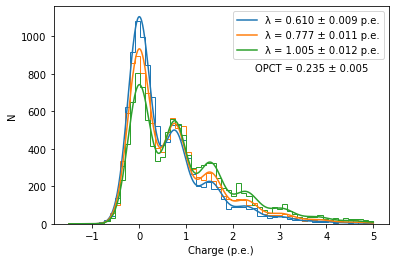

In [341]:
plot_fit(fit_lab)

In [307]:
with open('spe_lab.pkl', 'wb') as file:
    pickle.dump(fit_lab, file, protocol=pickle.HIGHEST_PROTOCOL)

In [308]:
plt.savefig("spe.pdf")

<Figure size 432x288 with 0 Axes>